In [20]:
# Import standard libraries
import os
os.environ["OMP_NUM_THREADS"] = '1'
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
import panel as pn
from panel.interact import interact, fixed

# ML import
from sklearn import datasets        # datasets
from sklearn.cluster import KMeans  # K-Means algorithm
from sklearn.cluster import AgglomerativeClustering  # Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage # dendogram visualization
from sklearn.preprocessing import LabelEncoder #Label encoding
from sklearn.preprocessing import OneHotEncoder # 1-hot encoding

#import from mlxtend for Association rule
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Assignment 2

Welcome to the second assignment! 

You will have to implement clustering, association rules, and recommender systems algorithms, applying these methods to: 
- explore the similarities within groups of people watching movies (clustering analysis)
- discover the relations between movies genre (association rules)
- recommend movies to users (recommender system)

We will use the MovieLens dataset, which contains movie ratings collected from the MovieLens website by the [GroupLens](https://grouplens.org/) research lab.

Source: F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. *ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>

Once you are done you have to submit your notebook here: 
[https://moodle.epfl.ch/mod/assign/view.php?id=1247726](https://moodle.epfl.ch/mod/assign/view.php?id=1247726)

If there is need for further clarifications on the questions, after the assignment is released, we will update this file, so make sure you check the git repository for updates.

Good luck!

## Clustering analysis: similarities between people (10 points)

In this section, you will try to form clusters of individuals based on their preferences regarding movie genres. You will use a transformed version of the MovieLens dataset containing, for a selection of users:
- their average rating of all science fiction movies they rated,
- their average rating of all comedy movies they rated.

Better understanding the differences in people's tastes can help improve the design of recommender systems, for instance for the creation of the user neighborhood. Ok, let's start!

- Load the data in a dataframe. The url link is provided below. Display the first 10 observations.

In [21]:
project_dir = r"C:\Users\Charlotte Ahrens\Documents\Personal\GitHub\MGT-502-Data-Science-and-Machine-Learning\data"

In [22]:
#load and siplay dataframe
#url_clustering = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/ratings_clustering.csv'
url_clustering = os.path.join(project_dir,"ratings_clustering.csv")
df_rating = pd.read_csv(url_clustering)
display(df_rating.head(10))
display(df_rating.describe())   

,avg_scifi_rating,avg_comedy_rating
0,3.50,2.71
1,2.56,2.64
2,2.00,3.20
3,3.18,2.83
4,3.00,3.90
5,2.33,3.20
6,3.00,3.63
7,2.30,3.40
8,3.11,3.39
9,2.85,2.47


,avg_scifi_rating,avg_comedy_rating
count,167.000000,167.000000
mean,2.837126,3.130479
std,0.648612,0.546989
min,0.500000,1.000000
25%,2.610000,2.805000
50%,2.890000,3.160000
75%,3.080000,3.435000
max,4.500000,4.830000


- Plot a dendogram using "ward" as linkage method and "euclidean" as metric. 
- Based on the dendogram, how many clusters do you think is optimal? Briefly justify your answer.

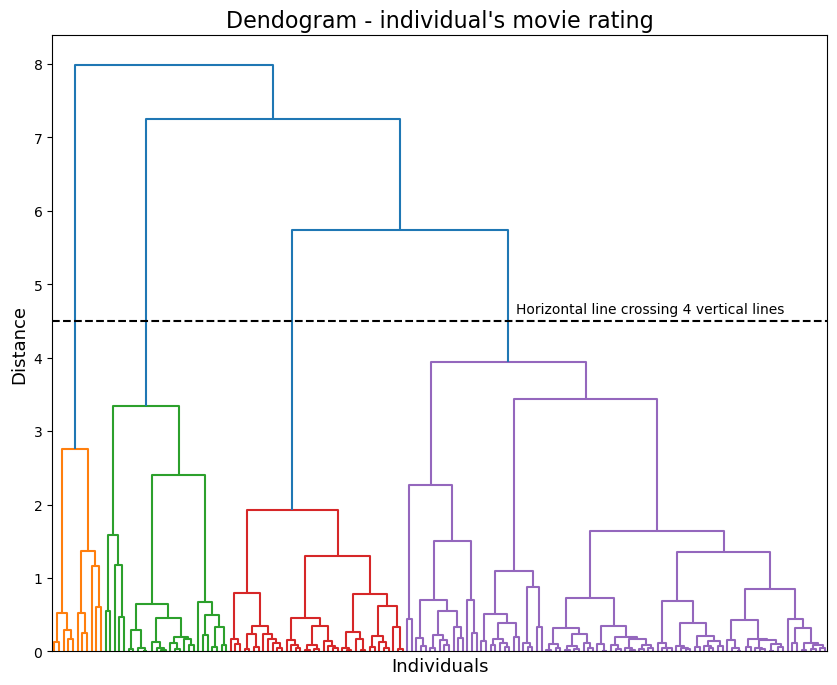

In [23]:
# plot dendogram
dendo_rating = linkage(df_rating, method="ward", metric="euclidean")

plt.figure(figsize=(10,8))
dendrogram(dendo_rating, show_leaf_counts=False)
plt.title("Dendogram - individual's movie rating", fontsize= 16)
plt.xlabel("Individuals", fontsize= 13)
plt.tick_params(axis = "x", labelbottom=False)
plt.ylabel("Distance", fontsize= 13)
plt.hlines(y= 4.5, xmin=0, xmax=2000, colors= "k", linestyle= "--")
plt.text(y= 4.6, x= 1000, s= "Horizontal line crossing 4 vertical lines")
plt.show()


### Explanation
Based on the above Dendogram, I would expect 4 clusters to be the optimal number to cluster the individuals based on their movie genre taste. I determined 4 clusters by loooking where I can find the longest vertical line that is not cut by a horizontal line. This distance can be found from ~y= 4 to ~y= 5.8 (Total distance: ~1.8) very close to this are 2 clusters since here we are having a distance from ~y= 5.8 to ~y=7.2 (Total distance= ~1.4). 

- Implement the Elbow method to determine the optimum number of cluster for K-Means algorithm (use `random_state=17` as parameter of K-Means). 
- Based on the Elbow method, how many clusters do you think is optimal? Briefly justify your answer.

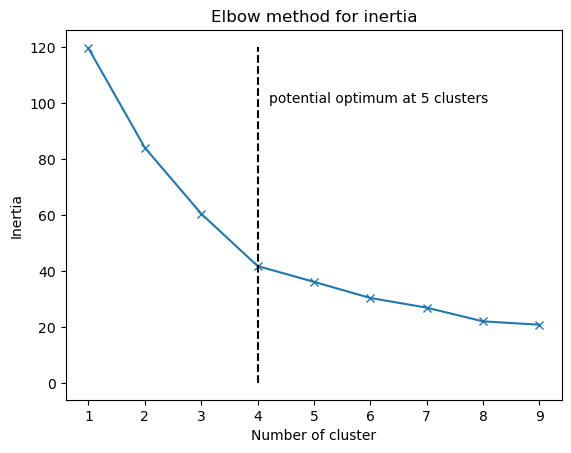

In [24]:
#elbow method for cluster determination 
inertias = []

poss_clusters = range(1,10)
for i in poss_clusters:
    km = KMeans(n_clusters = i, random_state = 17, n_init="auto")
    km.fit(df_rating)
    inertias.append(km.inertia_)

plt.plot(poss_clusters, inertias, "-x")
plt.vlines(x= 4, ymin=0, ymax= 120, linestyle= "--", colors="k")
plt.text(x= 4.2, y= 100, s= "potential optimum at 5 clusters")
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.title("Elbow method for inertia")
plt.show()


### Explanation

The elbow method confirms the previous finding of an optimal of 4 clusters. The Inertia measures how spread out the individuals ratings are within one cluster. The inertia decreases with an increasung # of clusters since the variance within the clusters decreases. Until 4 clusters, the inertia decreases, characterized by a steep slope, while from 4 clusters onwards the slope flattens. The "elbow" shows 4 to be the optimal cluster #.

- Implement (train) a K-Means algorithm with the number of clusters of your choice. Use `random_state=17` as parameter.

In [25]:
# K-means algorithm
kmeans4 = KMeans(n_clusters = 4, random_state = 17, n_init= "auto")
kmeans4.fit(df_rating)
display(kmeans4.cluster_centers_)                                                 

array([[2.83414286, 2.831     ],
       [1.47764706, 3.25588235],
       [3.931875  , 2.48125   ],
       [2.9278125 , 3.58703125]])

- Implement (train) a hierarchical algorithm with the same number of clusters as for the K-Means model. Use "ward" as linkage method and "euclidean" as metric/affinity 

In [26]:
# Hierarchical clustering
hierarchical4 = AgglomerativeClustering(n_clusters = 4, linkage = "ward", metric = "euclidean")
hierarchical4.fit(df_rating)

#determine the cluster centers
'''
labels = hierarchical4.fit_predict(df_rating)

# compute the centroid of each cluster
centroids = []
for i in range(4):
    centroid = np.mean(df_rating[labels == i], axis=0)
    centroids.append(centroid)

print(centroids)
'''

'\nlabels = hierarchical4.fit_predict(df_rating)\n\n# compute the centroid of each cluster\ncentroids = []\nfor i in range(4):\n    centroid = np.mean(df_rating[labels == i], axis=0)\n    centroids.append(centroid)\n\nprint(centroids)\n'

- Create a figure consisting of two subplots:
    - a scatterplot of 'avg_scifi_rating' and 'avg_comedy_rating' colored by the clusters predicted with your KMeans model. Add the cluster centers to your plot. Label your clusters with the name of your choice (e.g., "Comedy aficionado").
    - a scatterplot of 'avg_scifi_rating' and 'avg_comedy_rating' colored by the clusters predicted with your hierarchical algorithm model. Label your clusters with the name of your choice.
- How do your models compare?

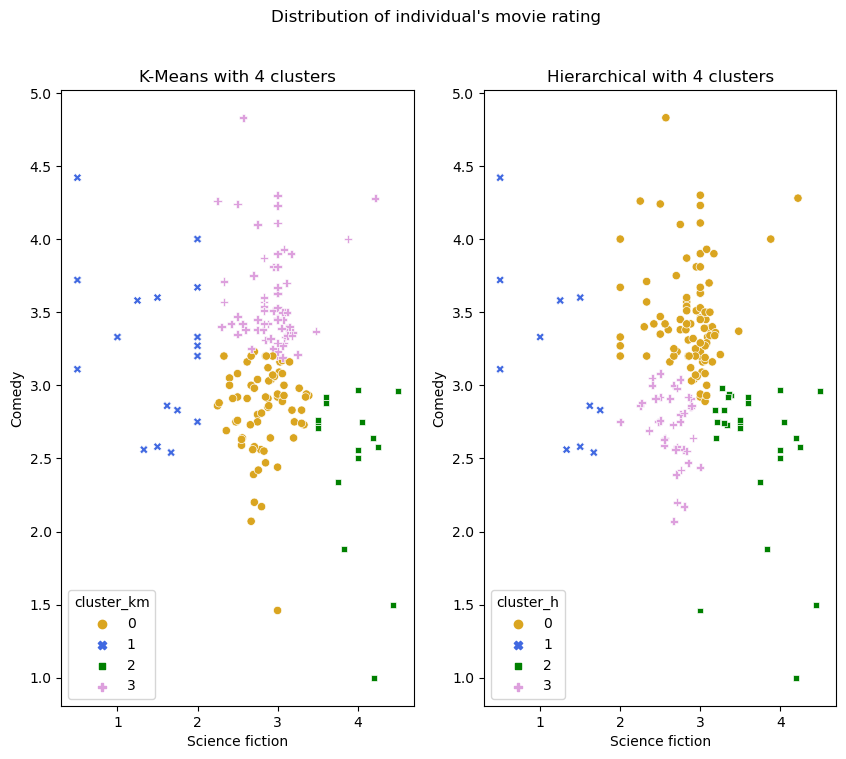

In [27]:
#add clusterlabels to the original dataframe df_rating
df_rating["cluster_km"] = kmeans4.labels_
df_rating["cluster_h"] = hierarchical4.labels_

# compare kMeans and hierarchical model
fig, ax =  plt.subplots(1,2, figsize= (10,8)) # creating 2 subplots next to another (1 row, 2 columns)
fig.suptitle("Distribution of individual's movie rating")

#kmean model

sns.scatterplot(data= df_rating, 
            x= "avg_scifi_rating",
            y= "avg_comedy_rating",
            hue= "cluster_km",
            ax = ax[0],
            palette = ['goldenrod','royalblue','green','plum'],
            style = "cluster_km") #varies the market style between the clusters
ax[0].set_title("K-Means with 4 clusters")
ax[0].set_xlabel("Science fiction")
ax[0].set_ylabel("Comedy")
#ax[0].legend(labels =["Imagination over fun ","Comedy lovers","Imagination geeks","Fun over Imagination"] )

#hierachical model
sns.scatterplot(data= df_rating, 
            x= "avg_scifi_rating",
            y= "avg_comedy_rating",
            hue= "cluster_h",
            ax = ax[1],
            palette = ['goldenrod','royalblue','green','plum'],
            style = "cluster_h")
           # markers=["x", "P", "*", "h"]) #varies the market style between the clusters)
ax[1].set_title("Hierarchical with 4 clusters")
ax[1].set_xlabel("Science fiction")
ax[1].set_ylabel("Comedy")
#ax[1].legend(labels =["Imagination over fun ","Comedy lovers","Imagination geeks","Fun over Imagination"] )
#adding a legend

#adding cluster centers

plt.show()

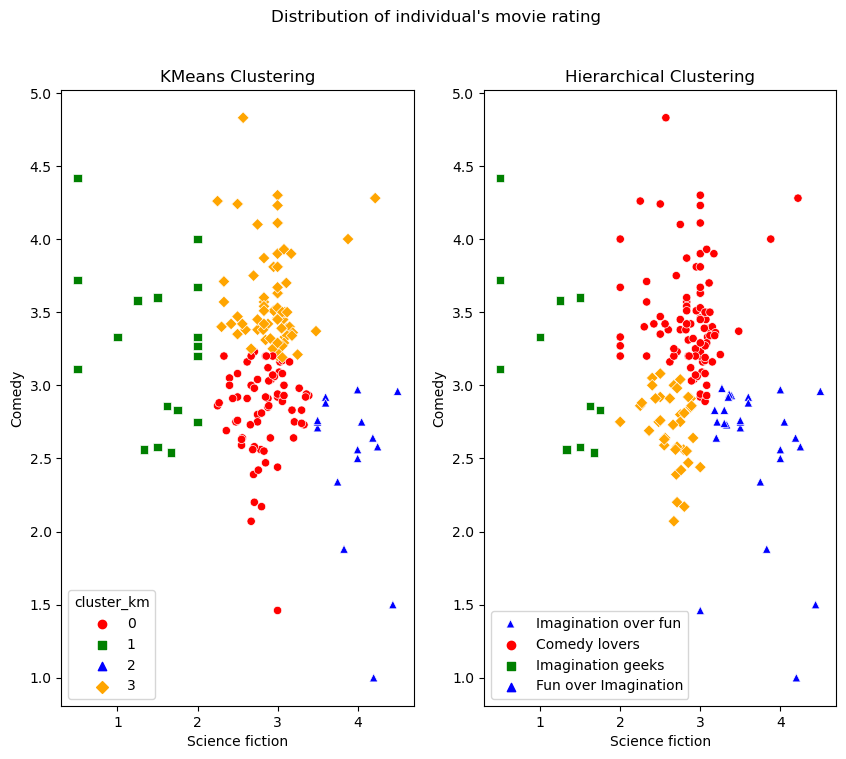

In [28]:
# add cluster labels to the original dataframe df_rating
df_rating["cluster_km"] = kmeans4.labels_
df_rating["cluster_h"] = hierarchical4.labels_

# compare kMeans and hierarchical model
fig, axs = plt.subplots(1, 2, figsize=(10, 8))  # creating 2 subplots next to another (1 row, 2 columns)
fig.suptitle("Distribution of individual's movie rating")

# k-means model

axs[0].set_title("KMeans Clustering")
axs[0].set_xlabel("Science fiction")
axs[0].set_ylabel("Comedy")
axs[0].legend(labels=["Imagination over fun", "Comedy lovers", "Imagination geeks", "Fun over Imagination"])
sns.scatterplot(data=df_rating,
                x="avg_scifi_rating",
                y="avg_comedy_rating",
                hue="cluster_km",
                palette=['red', 'green', 'blue', 'orange'],
                style="cluster_km",
                markers=["o", "s", "^", "D"],
                ax=axs[0])
# hierarchical model

axs[1].set_title("Hierarchical Clustering")
axs[1].set_xlabel("Science fiction")
axs[1].set_ylabel("Comedy")

sns.scatterplot(data=df_rating,
                x="avg_scifi_rating",
                y="avg_comedy_rating",
                hue="cluster_h",
                palette=['red', 'green', 'blue', 'orange'],
                style="cluster_h",
                markers=["o", "s", "^", "D"],
                ax=axs[1])
axs[1].legend(labels=["Imagination over fun", "Comedy lovers", "Imagination geeks", "Fun over Imagination"])
plt.show()


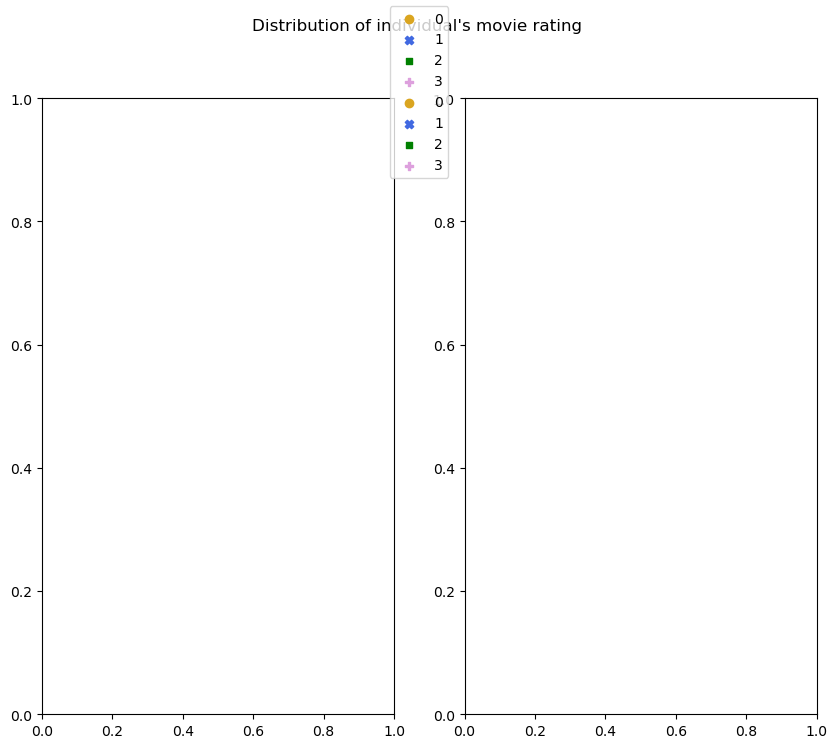

In [29]:
#kmean model
#add clusterlabels to the original dataframe df_rating
df_rating["cluster_km"] = kmeans4.labels_
df_rating["cluster_h"] = hierarchical4.labels_

# compare kMeans and hierarchical model
fig, axs =  plt.subplots(1,2, figsize= (10,8)) # creating 2 subplots next to another (1 row, 2 columns)
fig.suptitle("Distribution of individual's movie rating")

sns.scatterplot(data= df_rating, 
                x= "avg_scifi_rating",
                y= "avg_comedy_rating",
                hue= "cluster_km",
                ax = ax[0],
                palette = ['goldenrod','royalblue','green','plum'],
                style = "cluster_km") #varies the marker style between the clusters
ax[0].set_title("K-Means clustering")
ax[0].set_xlabel("Science fiction")
ax[0].set_ylabel("Comedy")
ax[0].legend(labels =["Imagination over fun ","Comedy lovers","Imagination geeks","Fun over Imagination"] )

#hierarchical model
sns.scatterplot(data= df_rating, 
                x= "avg_scifi_rating",
                y= "avg_comedy_rating",
                hue= "cluster_h",
                ax = ax[1],
                palette = ['goldenrod','royalblue','green','plum'],
                style = "cluster_h") #varies the marker style between the clusters
ax[1].set_title("Hierarchical clustering")
ax[1].set_xlabel("Science fiction")
ax[1].set_ylabel("Comedy")
ax[1].legend(labels =["Imagination over fun ","Comedy lovers","Imagination geeks","Fun over Imagination"] )

# add overall legend to the figure
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

### Explanation:
Depending on the model I am using the algorithm clsuters my unlabeld data into different clusters (even though I have the same number of clusters). For the K-Means model individuals with that rank science fiction very low have a wider range than for the hirearchical model. 

    Look at the distribution of the clusters: Check if the clusters in both models have similar or different sizes, and if there are any outliers or overlapping points.

    Check the similarity of the clusters: Look at the distribution of the points within each cluster and compare the clusters between the two models. Are the clusters similar in both models or are there any differences?

    Evaluate the performance of the models: Check the performance of the models by calculating the silhouette score. The silhouette score measures how well each point fits into its assigned cluster, and gives a value between -1 and 1. A higher silhouette score indicates that the clustering is better. Compare the silhouette scores of the two models to evaluate their performance.

    Consider the interpretation of the clusters: Finally, consider the interpretation of the clusters. Are the clusters meaningful and intuitive? Do they match your expectations based on the variables you used for clustering? Are there any insights you can gain from the clusters?

## Association Rules: association between movie genres (10 points)

You will now pursue your analysis, but this time trying to dig out information about movies. More precisely, you will search for matches between film genres using association rules. We try to understand, for instance, how likely it is that a film is both drama and action. This information can be interesting for film producers who may either want to produce something similar to the established norm: if most drama films are also action, perhaps the new action-drama film would be equally appreciated, or quite to the contrary try a new combination of genres which is more rare to find.

- Load the data in a dataframe. The url link is provided below. 
- Display the first 10 observations. 
- Print the unique values of genres from the first column. 
- How many unique genres does the first column contain? 
- How many movies does the dataframe contains?

In [40]:
#load and display movie genre dataframe
#url_association_rules = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/movies_assoc_rules.csv'
url_association_rules = os.path.join(project_dir,"movies_assoc_rules.csv")
df_movies = pd.read_csv(url_association_rules)
display(df_movies.head(10))
display(df_movies.describe())

#print the unique genres
print(df_movies["0"].unique())
print("The first column of the genre dataframe contains %d different genres." % len(df_movies["0"].unique()))

# convert the movie dataframe to a list 
movie_list = df_movies.values.tolist()

# delete all the nan'set
movie_list_cleaned = [[x for x in row if str(x) != "nan" ] for row in movie_list] # if my dataset would be numerical I could use: not math.isnan(x)
#display(movie_list_cleaned)

#Why are there all the unique values in columns 1? and I don't need to go through the entire datframe?
total_movies_list = [x for y in movie_list_cleaned for x in y]
#display (total_movies_list)
total_movies = set(total_movies_list)
print("The total number of different genres in the dataframe is %d" % len(total_movies))

#Total number of movies
non_nan = df_movies.count().sum()
print("The dataframe contains in total %d movies." %non_nan)


,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN,NaN,NaN
1,Adventure,Children,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Action,Crime,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adventure,Children,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Action,Adventure,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7,8,9
count,27032,16449,7640,2310,586,109,26,6,1,1
unique,19,18,17,16,14,10,8,3,1,1
top,Drama,Drama,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller,Thriller,Western
freq,7875,4452,1598,754,205,30,6,4,1,1


['Adventure' 'Comedy' 'Action' 'Drama' 'Crime' 'Children' 'Mystery'
 'Documentary' 'Animation' 'Thriller' 'Horror' 'Fantasy' 'Western'
 'Film-Noir' 'Romance' 'War' 'Sci-Fi' 'Musical' 'IMAX']
The first column of the genre dataframe contains 19 different genres.
The total number of different genres is 19
The dataframe contains in total 54160 movies


- Preprocessing: as seen during the lab, convert the dataset using a `Transaction Encoder` from the `mlextend` module so that the dataset is reorganised in columns of unique genres. Rows should contain only True or False boolean values according to whether a film was considered as belonging to a genre column or not. Check that you have the correct dimensions.

In [45]:
#create the encoder
te = TransactionEncoder()

#fit and transform the data
movie_list_encoded= te.fit(movie_list_cleaned).transform(movie_list_cleaned)

#create dataframe with type of genre as header
df_movie_encoded = pd.DataFrame(movie_list_encoded, columns=te.columns_)
display(df_movie_encoded.head(10))

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
6,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
7,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,27032,27032,27032,27032,27032,27032,27032,27032,27032,27032,27032,27032,27032,27032,27032,27032,27032,27032,27032
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,23512,24703,26005,25893,18658,24093,24561,13688,25620,26702,24421,26836,25996,25518,22905,25289,22854,25838,26356


- Frequent itemsets: using the Apriori algorithm to find the frequent itemsets with minimum support of 0.01. There is no condition on the maximum length of an itemset. 
- How many itemsets did the apriori algorithm return above (for min_support=0.01)? 
- What are the 10 itemsets with the largest support (you can directly display a dataframe with the 10 itemsets and their support)?

In [50]:
#determine frequent itemsets with min support 0.01 and no max_len
freq_items = apriori(df_movie_encoded, min_support= 0.01, use_colnames= True)
display(freq_items.sort_values(by="support",ascending=False).head(10))
display("With a minimum support of 0.01, the Apriori algorithm returned %d itemsets." %len(freq_items["support"]))

,support,itemsets
7,0.493637,(Drama)
4,0.309781,(Comedy)
15,0.154558,(Thriller)
13,0.152671,(Romance)
0,0.130216,(Action)
5,0.108723,(Crime)
10,0.096589,(Horror)
53,0.095183,"(Drama, Romance)"
39,0.094185,"(Drama, Comedy)"
6,0.091410,(Documentary)


'With a minimum support of 0.01, the Apriori algorithm returned 69 itemsets.'

The itemseets with the largest support are Drama with a support on fearly 0.5. It is followed by Comedy with a support of 0.31. After, thriller and romance are following with a very similar support at ~0.15.

- Mining for association rules: using the frequent items identified above, find association rules with a minimum confidence of 0.45 and order them by decreasing value of lift.
- Discuss the following statements (true or false with 1-2 lines justification)
    - Animation films are associated with Children.  
    - If a film has the genre Musical, then it is also a Comedy.
    - If War then Drama is the asociation rule with the highest confidence.  

In [54]:
# mine for association rules with confidence >= 0.45

rules_genre = association_rules(freq_items, metric = "confidence", min_threshold = 0.45)
rules_genre.sort_values(by = "lift", ascending=False) #double check why it is not sorting correctly 
display(rules_genre)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Animation),(Children),0.037992,0.042135,0.017387,0.457644,10.861301,0.015786,1.766117,0.943786
1,(Children),(Comedy),0.042135,0.309781,0.019458,0.461809,1.490758,0.006406,1.282479,0.343682
2,(Musical),(Comedy),0.038325,0.309781,0.018238,0.475869,1.536146,0.006365,1.316882,0.362929
3,(Romance),(Comedy),0.152671,0.309781,0.070102,0.459171,1.482245,0.022808,1.276225,0.383968
4,(Crime),(Drama),0.108723,0.493637,0.063332,0.582511,1.180039,0.009663,1.212877,0.171182
5,(Mystery),(Drama),0.056008,0.493637,0.026672,0.476222,0.964721,-0.000975,0.966751,-0.037295
6,(Romance),(Drama),0.152671,0.493637,0.095183,0.623455,1.262983,0.019819,1.344762,0.245741
7,(War),(Drama),0.044170,0.493637,0.033072,0.748744,1.516790,0.011268,2.015324,0.356457
8,(Mystery),(Thriller),0.056008,0.154558,0.029410,0.525099,3.397434,0.020753,1.780250,0.747527
9,"(Action, Crime)",(Thriller),0.028374,0.154558,0.014612,0.514993,3.332050,0.010227,1.743157,0.720323


### Discussion - double check
1. Animation films are associated with Children. True, since it has a high lift with ~10.9 which measures the strength of the association between the antecedent and the consequent.
2. If a film has the genre Musical, then it is also a Comedy. False. There is an association between Musical and Coemdy, meaning 
3. If War then Drama is the asociation rule with the highest confidence. True, if war is the antecedent, then the consequent "Drama" has a confidence of ~0.75. 


## Recommender systems: item-based recommender system (10 points)

In the walkthrough, we have implemented a user-to-user collaborative filtering algorithm (from scratch and using using Surprise library), i.e., our recommendations were based on the ratings of users with similar tastes. In this assignment, you will implement an **item-to-item** collaborative filtering algorithm, i.e., the recommendations will be based on the set of movies that users like. Do not worry, you won't have to implement the algorithm from scratch and instead can rely on the [Surprise library](http://surpriselib.com/). 

- As in the walkthrough, load the *built-in* `ml-100k` from the Surprise library.

In [ ]:
# YOUR CODE HERE



- Use GridSearchCV to find the best number of neighbors (k) for a KNNWithMeans **item-based** algorithm, with the following parameters:
    - options for k: `[10, 20, 30, 40, 50]`
    - `'sim_options': {'name': ['pearson'], 'user_based': [???]}` Here you have to replace `???` with the appropriate value...
    - root-mean-square-error (RMSE) as measures,
    - 5 cross-validation folds,
    - other parameters: `refit=True, joblib_verbose=2, n_jobs=-1`
- What is the optimal k for which GridSearchCV returned the best RMSE score? 
- What is the RMSE score for the optimal k?

In [ ]:
# YOUR CODE HERE



- Using the Surprise library, split your dataset between training and test set. As parameters, use `test_size=0.2, random_state=12`
- Fit a KNNWithMeans algorithm using the best k value retrieved above. As other parameters, use:
    - `min_k=1`
    - `sim_options = {'name': 'pearson','user_based': ???}`
    - `verbose=False`
- Predict ratings on the test set using your algorithm

In [ ]:
# YOUR CODE HERE



- Use the helper function below to identify the best 10 films for all users
- Find the top 10 predictions for user 169 (you should return the titles of the movies)

In [ ]:
def read_item_names():
    '''Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    '''

    file_name = get_dataset_dir() + '/ml-100k/ml-100k/u.item'
    rid_to_name = {}
    name_to_rid = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list) # This is used to group a sequence of key-value pairs into a dictionary of lists
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [ ]:
# YOUR CODE HERE



- Plot the precision at rank k and the recall at rank k on the same figure, for k between 0 and 20, and a relevance threshold of 3.75
- Plot the precision-recall curve

*You can, but do not have to, rely on the function(s) used in the lab (i.e., copying the code of the function(s))*

In [ ]:
# YOUR CODE HERE



Congrats, you are done with the assignment!